In [1]:
# imports required for the algorithm
import os

import time

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)
    
    dataset.drop('Precipitacao', axis=1, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                              
2015-01-01        35.0        23.7        5.9              10.2   
2015-01-02        35.8        23.0       10.6              10.2   
2015-01-03        31.9        22.3        4.3               6.2   
2015-01-04        27.3        20.7        1.9               3.5   
2015-01-05        32.4        20.7        8.3               1.5   
...                ...         ...        ...               ...   
2018-04-26        31.0        20.8        8.9               0.5   
2018-04-27        31.7        22.9       10.5               0.5   
2018-04-28        31.3        21.5        9.5               0.5   
2018-04-29        28.9        22.7        2.5               0.5   
2018-04-30        28.9        21.9        2.5               0.5   

            Temp Comp Media  Umidade Relativa Media  Velocidade do Vento Media  
date                                           

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values
features = len(dataset.columns)

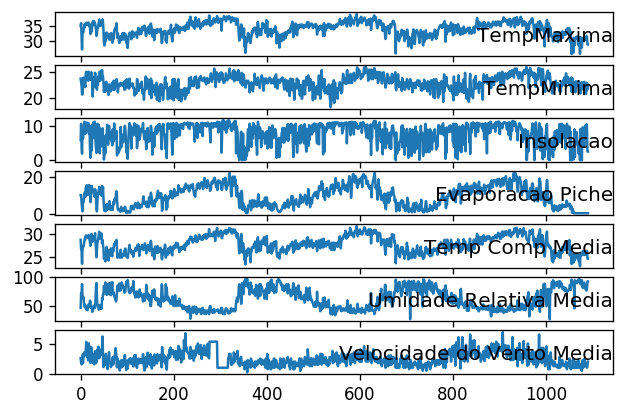

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,features)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,features)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,features)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,features)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
        
    return [y_hats, y_tests]

In [11]:
def metrics(y_hats, y_tests):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    percentual = 100
    n = len(y_hats)
    j = 1
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nErrors')
    for i in range(0,len(y_hats_max)):
        error = abs(y_hats_max[i] - y_tests_max[i])
        print('{}/04/2018 = {}'.format(30-i,error))
    
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_max[i] - y_tests_max[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1
    
    print('\nMinimum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))
    
    print('\nErrors')
    for i in range(0,len(y_hats_min)):
        error = abs(y_hats_min[i] - y_tests_min[i])
        print('{}/04/2018 = {}'.format(30-i,error))
    
    j = 1
    percentual = 100
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_min[i] - y_tests_min[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4028 - mean_squared_error: 0.2216 - val_loss: 0.2147 - val_mean_squared_error: 0.0625
Epoch 2/1000
 - 1s - loss: 0.1639 - mean_squared_error: 0.0427 - val_loss: 0.1144 - val_mean_squared_error: 0.0257
Epoch 3/1000
 - 1s - loss: 0.1397 - mean_squared_error: 0.0304 - val_loss: 0.1657 - val_mean_squared_error: 0.0523
Epoch 4/1000
 - 1s - loss: 0.1338 - mean_squared_error: 0.0282 - val_loss: 0.1474 - val_mean_squared_error: 0.0368
Epoch 5/1000
 - 1s - loss: 0.1297 - mean_squared_error: 0.0264 - val_loss: 0.1513 - val_mean_squared_error: 0.0423
Epoch 6/1000
 - 1s - loss: 0.1252 - mean_squared_error: 0.0249 - val_loss: 0.1528 - val_mean_squared_error: 0.0445
Epoch 7/1000
 - 1s - loss: 0.1217 - mean_squared_error: 0.0235 - val_loss: 0.1606 - val_mean_squared_error: 0.0437
Epoch 8/1000
 - 1s - loss: 0.1175 - mean_squared_error: 0.0223 - val_loss: 0.1554 - val_mean_squared_error: 0.0375
Epoch 9/1000
 - 1s - loss: 0.1145 -

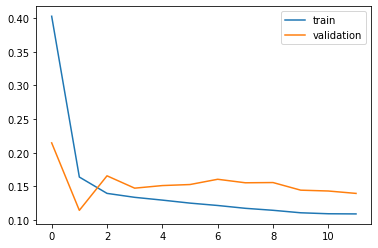


predict: [[31.39886566 22.68069196]]
real:      [[28.9 21.9]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2494 - mean_squared_error: 0.1075 - val_loss: 0.1408 - val_mean_squared_error: 0.0214
Epoch 2/1000
 - 1s - loss: 0.1365 - mean_squared_error: 0.0298 - val_loss: 0.1748 - val_mean_squared_error: 0.0310
Epoch 3/1000
 - 1s - loss: 0.1280 - mean_squared_error: 0.0264 - val_loss: 0.1718 - val_mean_squared_error: 0.0310
Epoch 4/1000
 - 1s - loss: 0.1201 - mean_squared_error: 0.0236 - val_loss: 0.1554 - val_mean_squared_error: 0.0248
Epoch 5/1000
 - 1s - loss: 0.1159 - mean_squared_error: 0.0220 - val_loss: 0.1702 - val_mean_squared_error: 0.0292
Epoch 6/1000
 - 1s - loss: 0.1133 - mean_squared_error: 0.0211 - val_loss: 0.1691 - val_mean_squared_error: 0.0295
Epoch 7/1000
 - 1s - loss: 0.1094 - mean_squared_error: 0.0200 - val_loss: 0.1545 - val_mean_squared_error: 0.0250
Epoch 8/1000
 - 1s - loss: 0.1065 - mean_squared_error: 0.0189 - val_loss: 0.1556 - va

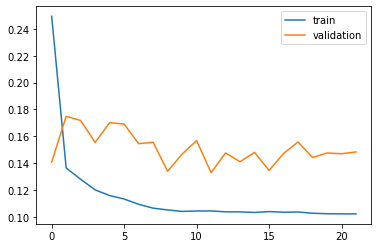


predict: [[31.71539147 22.64289629]]
real:      [[28.9 22.7]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3015 - mean_squared_error: 0.1431 - val_loss: 0.0843 - val_mean_squared_error: 0.0073
Epoch 2/1000
 - 1s - loss: 0.1519 - mean_squared_error: 0.0370 - val_loss: 0.0787 - val_mean_squared_error: 0.0085
Epoch 3/1000
 - 1s - loss: 0.1355 - mean_squared_error: 0.0292 - val_loss: 0.0321 - val_mean_squared_error: 0.0015
Epoch 4/1000
 - 1s - loss: 0.1281 - mean_squared_error: 0.0267 - val_loss: 0.0556 - val_mean_squared_error: 0.0041
Epoch 5/1000
 - 1s - loss: 0.1223 - mean_squared_error: 0.0245 - val_loss: 0.0406 - val_mean_squared_error: 0.0020
Epoch 6/1000
 - 1s - loss: 0.1154 - mean_squared_error: 0.0223 - val_loss: 0.0436 - val_mean_squared_error: 0.0032
Epoch 7/1000
 - 1s - loss: 0.1127 - mean_squared_error: 0.0211 - val_loss: 0.0559 - val_mean_squared_error: 0.0032
Epoch 8/1000
 - 1s - loss: 0.1142 - mean_squared_error: 0.0219 - val_loss: 0.0653 - va

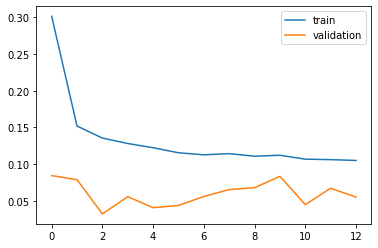


predict: [[32.15371411 22.5891638 ]]
real:      [[31.3 21.5]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3787 - mean_squared_error: 0.2033 - val_loss: 0.2843 - val_mean_squared_error: 0.0995
Epoch 2/1000
 - 1s - loss: 0.1644 - mean_squared_error: 0.0448 - val_loss: 0.1545 - val_mean_squared_error: 0.0250
Epoch 3/1000
 - 1s - loss: 0.1412 - mean_squared_error: 0.0326 - val_loss: 0.1446 - val_mean_squared_error: 0.0214
Epoch 4/1000
 - 1s - loss: 0.1372 - mean_squared_error: 0.0299 - val_loss: 0.1892 - val_mean_squared_error: 0.0368
Epoch 5/1000
 - 1s - loss: 0.1317 - mean_squared_error: 0.0280 - val_loss: 0.2246 - val_mean_squared_error: 0.0521
Epoch 6/1000
 - 1s - loss: 0.1282 - mean_squared_error: 0.0269 - val_loss: 0.1978 - val_mean_squared_error: 0.0407
Epoch 7/1000
 - 1s - loss: 0.1231 - mean_squared_error: 0.0249 - val_loss: 0.2137 - val_mean_squared_error: 0.0471
Epoch 8/1000
 - 1s - loss: 0.1137 - mean_squared_error: 0.0218 - val_loss: 0.2252 - va

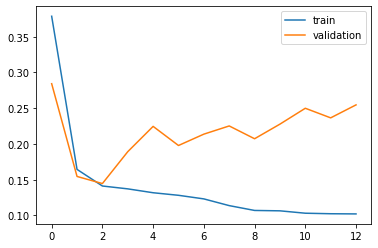


predict: [[32.22598844 22.20540702]]
real:      [[31.7 22.9]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4418 - mean_squared_error: 0.2440 - val_loss: 0.1305 - val_mean_squared_error: 0.0210
Epoch 2/1000
 - 1s - loss: 0.1489 - mean_squared_error: 0.0362 - val_loss: 0.1835 - val_mean_squared_error: 0.0355
Epoch 3/1000
 - 1s - loss: 0.1363 - mean_squared_error: 0.0294 - val_loss: 0.2355 - val_mean_squared_error: 0.0555
Epoch 4/1000
 - 1s - loss: 0.1316 - mean_squared_error: 0.0278 - val_loss: 0.2163 - val_mean_squared_error: 0.0476
Epoch 5/1000
 - 1s - loss: 0.1306 - mean_squared_error: 0.0273 - val_loss: 0.2163 - val_mean_squared_error: 0.0472
Epoch 6/1000
 - 1s - loss: 0.1280 - mean_squared_error: 0.0270 - val_loss: 0.1974 - val_mean_squared_error: 0.0398
Epoch 7/1000
 - 1s - loss: 0.1274 - mean_squared_error: 0.0266 - val_loss: 0.1910 - val_mean_squared_error: 0.0369
Epoch 8/1000
 - 1s - loss: 0.1233 - mean_squared_error: 0.0247 - val_loss: 0.2172 - va

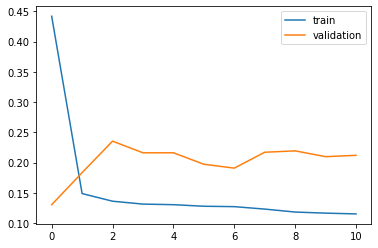


predict: [[32.7428668  21.01890452]]
real:      [[31.  20.8]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2800 - mean_squared_error: 0.1146 - val_loss: 0.1656 - val_mean_squared_error: 0.0275
Epoch 2/1000
 - 1s - loss: 0.1507 - mean_squared_error: 0.0367 - val_loss: 0.1522 - val_mean_squared_error: 0.0262
Epoch 3/1000
 - 1s - loss: 0.1371 - mean_squared_error: 0.0298 - val_loss: 0.1757 - val_mean_squared_error: 0.0313
Epoch 4/1000
 - 1s - loss: 0.1298 - mean_squared_error: 0.0269 - val_loss: 0.1685 - val_mean_squared_error: 0.0287
Epoch 5/1000
 - 1s - loss: 0.1215 - mean_squared_error: 0.0241 - val_loss: 0.1388 - val_mean_squared_error: 0.0197
Epoch 6/1000
 - 1s - loss: 0.1131 - mean_squared_error: 0.0209 - val_loss: 0.1251 - val_mean_squared_error: 0.0166
Epoch 7/1000
 - 1s - loss: 0.1102 - mean_squared_error: 0.0199 - val_loss: 0.1141 - val_mean_squared_error: 0.0149
Epoch 8/1000
 - 1s - loss: 0.1107 - mean_squared_error: 0.0201 - val_loss: 0.1093 - va

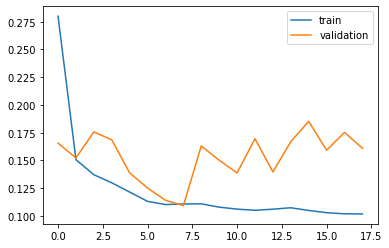


predict: [[31.86500152 22.28730042]]
real:      [[30.7 21. ]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2821 - mean_squared_error: 0.1225 - val_loss: 0.1744 - val_mean_squared_error: 0.0344
Epoch 2/1000
 - 1s - loss: 0.1542 - mean_squared_error: 0.0377 - val_loss: 0.1043 - val_mean_squared_error: 0.0204
Epoch 3/1000
 - 1s - loss: 0.1386 - mean_squared_error: 0.0308 - val_loss: 0.1116 - val_mean_squared_error: 0.0174
Epoch 4/1000
 - 1s - loss: 0.1317 - mean_squared_error: 0.0273 - val_loss: 0.1480 - val_mean_squared_error: 0.0244
Epoch 5/1000
 - 1s - loss: 0.1294 - mean_squared_error: 0.0267 - val_loss: 0.1469 - val_mean_squared_error: 0.0271
Epoch 6/1000
 - 1s - loss: 0.1245 - mean_squared_error: 0.0249 - val_loss: 0.1210 - val_mean_squared_error: 0.0203
Epoch 7/1000
 - 1s - loss: 0.1212 - mean_squared_error: 0.0236 - val_loss: 0.1325 - val_mean_squared_error: 0.0212
Epoch 8/1000
 - 1s - loss: 0.1157 - mean_squared_error: 0.0220 - val_loss: 0.1843 - va

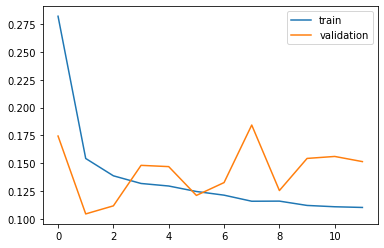


predict: [[32.32879691 22.1449326 ]]
real:      [[30.6 21.7]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3976 - mean_squared_error: 0.2049 - val_loss: 0.1855 - val_mean_squared_error: 0.0623
Epoch 2/1000
 - 1s - loss: 0.1678 - mean_squared_error: 0.0466 - val_loss: 0.1614 - val_mean_squared_error: 0.0262
Epoch 3/1000
 - 1s - loss: 0.1405 - mean_squared_error: 0.0318 - val_loss: 0.1368 - val_mean_squared_error: 0.0312
Epoch 4/1000
 - 1s - loss: 0.1349 - mean_squared_error: 0.0290 - val_loss: 0.1336 - val_mean_squared_error: 0.0239
Epoch 5/1000
 - 1s - loss: 0.1314 - mean_squared_error: 0.0275 - val_loss: 0.1156 - val_mean_squared_error: 0.0257
Epoch 6/1000
 - 1s - loss: 0.1299 - mean_squared_error: 0.0271 - val_loss: 0.1178 - val_mean_squared_error: 0.0244
Epoch 7/1000
 - 1s - loss: 0.1274 - mean_squared_error: 0.0260 - val_loss: 0.0990 - val_mean_squared_error: 0.0193
Epoch 8/1000
 - 1s - loss: 0.1275 - mean_squared_error: 0.0260 - val_loss: 0.1262 - va

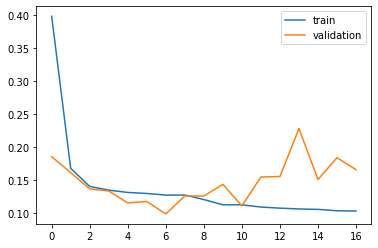


predict: [[31.29245912 22.84352248]]
real:      [[30.3 22.3]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5266 - mean_squared_error: 0.3121 - val_loss: 0.2960 - val_mean_squared_error: 0.0989
Epoch 2/1000
 - 1s - loss: 0.2160 - mean_squared_error: 0.0708 - val_loss: 0.1858 - val_mean_squared_error: 0.0441
Epoch 3/1000
 - 1s - loss: 0.1375 - mean_squared_error: 0.0293 - val_loss: 0.0962 - val_mean_squared_error: 0.0125
Epoch 4/1000
 - 1s - loss: 0.1360 - mean_squared_error: 0.0285 - val_loss: 0.1180 - val_mean_squared_error: 0.0148
Epoch 5/1000
 - 1s - loss: 0.1316 - mean_squared_error: 0.0269 - val_loss: 0.0942 - val_mean_squared_error: 0.0134
Epoch 6/1000
 - 1s - loss: 0.1264 - mean_squared_error: 0.0253 - val_loss: 0.0804 - val_mean_squared_error: 0.0103
Epoch 7/1000
 - 1s - loss: 0.1158 - mean_squared_error: 0.0217 - val_loss: 0.0639 - val_mean_squared_error: 0.0058
Epoch 8/1000
 - 1s - loss: 0.1111 - mean_squared_error: 0.0201 - val_loss: 0.0581 - va

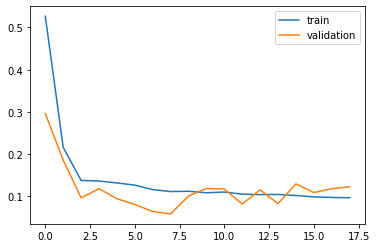


predict: [[31.21933981 22.33514307]]
real:      [[30.  23.1]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4430 - mean_squared_error: 0.2537 - val_loss: 0.3256 - val_mean_squared_error: 0.1062
Epoch 2/1000
 - 1s - loss: 0.2046 - mean_squared_error: 0.0626 - val_loss: 0.0995 - val_mean_squared_error: 0.0148
Epoch 3/1000
 - 1s - loss: 0.1441 - mean_squared_error: 0.0338 - val_loss: 0.1057 - val_mean_squared_error: 0.0136
Epoch 4/1000
 - 1s - loss: 0.1393 - mean_squared_error: 0.0309 - val_loss: 0.0970 - val_mean_squared_error: 0.0129
Epoch 5/1000
 - 1s - loss: 0.1333 - mean_squared_error: 0.0287 - val_loss: 0.0864 - val_mean_squared_error: 0.0089
Epoch 6/1000
 - 1s - loss: 0.1293 - mean_squared_error: 0.0270 - val_loss: 0.0933 - val_mean_squared_error: 0.0109
Epoch 7/1000
 - 1s - loss: 0.1230 - mean_squared_error: 0.0252 - val_loss: 0.1164 - val_mean_squared_error: 0.0155
Epoch 8/1000
 - 1s - loss: 0.1163 - mean_squared_error: 0.0229 - val_loss: 0.0774 - va

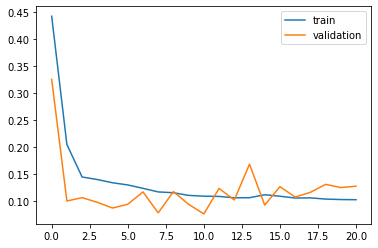


predict: [[30.56254529 22.26953032]]
real:      [[31.1 22.8]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2228 - mean_squared_error: 0.0804 - val_loss: 0.0804 - val_mean_squared_error: 0.0112
Epoch 2/1000
 - 1s - loss: 0.1406 - mean_squared_error: 0.0313 - val_loss: 0.0777 - val_mean_squared_error: 0.0110
Epoch 3/1000
 - 1s - loss: 0.1309 - mean_squared_error: 0.0275 - val_loss: 0.0715 - val_mean_squared_error: 0.0093
Epoch 4/1000
 - 1s - loss: 0.1246 - mean_squared_error: 0.0255 - val_loss: 0.0757 - val_mean_squared_error: 0.0100
Epoch 5/1000
 - 1s - loss: 0.1184 - mean_squared_error: 0.0231 - val_loss: 0.0832 - val_mean_squared_error: 0.0100
Epoch 6/1000
 - 1s - loss: 0.1127 - mean_squared_error: 0.0212 - val_loss: 0.1130 - val_mean_squared_error: 0.0154
Epoch 7/1000
 - 1s - loss: 0.1098 - mean_squared_error: 0.0201 - val_loss: 0.0698 - val_mean_squared_error: 0.0094
Epoch 8/1000
 - 1s - loss: 0.1078 - mean_squared_error: 0.0193 - val_loss: 0.0806 - va

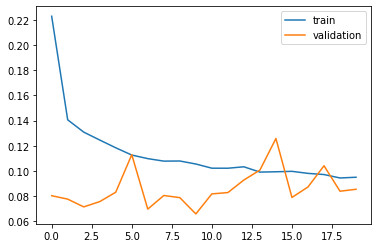


predict: [[31.20388638 22.2475451 ]]
real:      [[31.1 22.3]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5036 - mean_squared_error: 0.2980 - val_loss: 0.0390 - val_mean_squared_error: 0.0015
Epoch 2/1000
 - 1s - loss: 0.1650 - mean_squared_error: 0.0436 - val_loss: 0.1061 - val_mean_squared_error: 0.0114
Epoch 3/1000
 - 1s - loss: 0.1449 - mean_squared_error: 0.0326 - val_loss: 0.2135 - val_mean_squared_error: 0.0466
Epoch 4/1000
 - 1s - loss: 0.1379 - mean_squared_error: 0.0296 - val_loss: 0.1634 - val_mean_squared_error: 0.0268
Epoch 5/1000
 - 1s - loss: 0.1335 - mean_squared_error: 0.0281 - val_loss: 0.1640 - val_mean_squared_error: 0.0270
Epoch 6/1000
 - 1s - loss: 0.1293 - mean_squared_error: 0.0266 - val_loss: 0.1354 - val_mean_squared_error: 0.0187
Epoch 7/1000
 - 1s - loss: 0.1269 - mean_squared_error: 0.0255 - val_loss: 0.1913 - val_mean_squared_error: 0.0375
Epoch 8/1000
 - 1s - loss: 0.1211 - mean_squared_error: 0.0235 - val_loss: 0.1959 - va

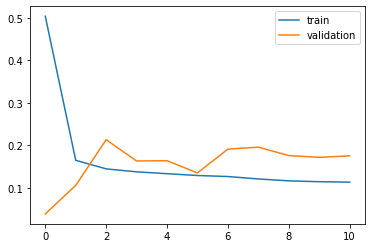


predict: [[28.5589611 20.9138429]]
real:      [[31.  22.8]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3745 - mean_squared_error: 0.1905 - val_loss: 0.3022 - val_mean_squared_error: 0.1412
Epoch 2/1000
 - 1s - loss: 0.1665 - mean_squared_error: 0.0460 - val_loss: 0.2243 - val_mean_squared_error: 0.0574
Epoch 3/1000
 - 1s - loss: 0.1490 - mean_squared_error: 0.0348 - val_loss: 0.2068 - val_mean_squared_error: 0.0834
Epoch 4/1000
 - 1s - loss: 0.1389 - mean_squared_error: 0.0302 - val_loss: 0.1854 - val_mean_squared_error: 0.0673
Epoch 5/1000
 - 1s - loss: 0.1322 - mean_squared_error: 0.0276 - val_loss: 0.2052 - val_mean_squared_error: 0.0789
Epoch 6/1000
 - 1s - loss: 0.1259 - mean_squared_error: 0.0256 - val_loss: 0.2008 - val_mean_squared_error: 0.0725
Epoch 7/1000
 - 1s - loss: 0.1174 - mean_squared_error: 0.0224 - val_loss: 0.2278 - val_mean_squared_error: 0.0866
Epoch 8/1000
 - 1s - loss: 0.1124 - mean_squared_error: 0.0209 - val_loss: 0.2210 - val_

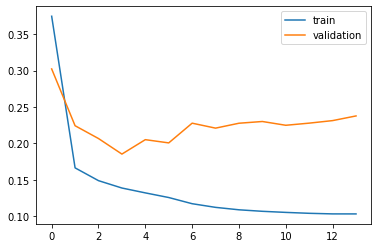


predict: [[31.50664215 22.77708981]]
real:      [[30.7 21.7]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5476 - mean_squared_error: 0.3416 - val_loss: 0.2887 - val_mean_squared_error: 0.1237
Epoch 2/1000
 - 1s - loss: 0.2218 - mean_squared_error: 0.0810 - val_loss: 0.1856 - val_mean_squared_error: 0.0369
Epoch 3/1000
 - 1s - loss: 0.1470 - mean_squared_error: 0.0351 - val_loss: 0.1723 - val_mean_squared_error: 0.0376
Epoch 4/1000
 - 1s - loss: 0.1416 - mean_squared_error: 0.0311 - val_loss: 0.1558 - val_mean_squared_error: 0.0476
Epoch 5/1000
 - 1s - loss: 0.1352 - mean_squared_error: 0.0290 - val_loss: 0.1268 - val_mean_squared_error: 0.0300
Epoch 6/1000
 - 1s - loss: 0.1338 - mean_squared_error: 0.0284 - val_loss: 0.1443 - val_mean_squared_error: 0.0373
Epoch 7/1000
 - 1s - loss: 0.1312 - mean_squared_error: 0.0271 - val_loss: 0.1632 - val_mean_squared_error: 0.0487
Epoch 8/1000
 - 1s - loss: 0.1298 - mean_squared_error: 0.0267 - val_loss: 0.1485 - va

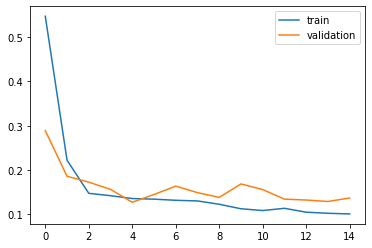


predict: [[31.73129626 22.74093761]]
real:      [[27.9 23. ]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3323 - mean_squared_error: 0.1686 - val_loss: 0.2978 - val_mean_squared_error: 0.0888
Epoch 2/1000
 - 1s - loss: 0.1585 - mean_squared_error: 0.0395 - val_loss: 0.0637 - val_mean_squared_error: 0.0048
Epoch 3/1000
 - 1s - loss: 0.1422 - mean_squared_error: 0.0321 - val_loss: 0.1558 - val_mean_squared_error: 0.0256
Epoch 4/1000
 - 1s - loss: 0.1367 - mean_squared_error: 0.0292 - val_loss: 0.1527 - val_mean_squared_error: 0.0238
Epoch 5/1000
 - 1s - loss: 0.1305 - mean_squared_error: 0.0275 - val_loss: 0.1465 - val_mean_squared_error: 0.0228
Epoch 6/1000
 - 1s - loss: 0.1254 - mean_squared_error: 0.0251 - val_loss: 0.2187 - val_mean_squared_error: 0.0486
Epoch 7/1000
 - 1s - loss: 0.1211 - mean_squared_error: 0.0241 - val_loss: 0.2209 - val_mean_squared_error: 0.0491
Epoch 8/1000
 - 1s - loss: 0.1136 - mean_squared_error: 0.0216 - val_loss: 0.2638 - va

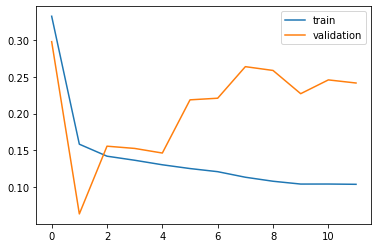


predict: [[30.58441611 22.26599922]]
real:      [[29.5 23. ]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4391 - mean_squared_error: 0.2523 - val_loss: 0.1631 - val_mean_squared_error: 0.0381
Epoch 2/1000
 - 1s - loss: 0.1714 - mean_squared_error: 0.0468 - val_loss: 0.1913 - val_mean_squared_error: 0.0434
Epoch 3/1000
 - 1s - loss: 0.1511 - mean_squared_error: 0.0352 - val_loss: 0.2547 - val_mean_squared_error: 0.0657
Epoch 4/1000
 - 1s - loss: 0.1393 - mean_squared_error: 0.0311 - val_loss: 0.1799 - val_mean_squared_error: 0.0377
Epoch 5/1000
 - 1s - loss: 0.1315 - mean_squared_error: 0.0271 - val_loss: 0.1896 - val_mean_squared_error: 0.0389
Epoch 6/1000
 - 1s - loss: 0.1194 - mean_squared_error: 0.0228 - val_loss: 0.1466 - val_mean_squared_error: 0.0220
Epoch 7/1000
 - 1s - loss: 0.1161 - mean_squared_error: 0.0218 - val_loss: 0.1809 - val_mean_squared_error: 0.0348
Epoch 8/1000
 - 1s - loss: 0.1099 - mean_squared_error: 0.0201 - val_loss: 0.1355 - va

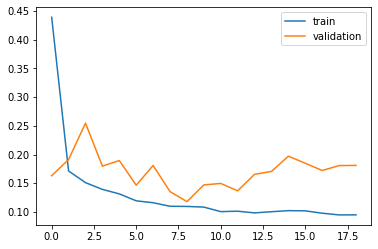


predict: [[31.42237531 22.34875195]]
real:      [[30.7 21.8]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4093 - mean_squared_error: 0.2391 - val_loss: 0.3649 - val_mean_squared_error: 0.1797
Epoch 2/1000
 - 1s - loss: 0.1585 - mean_squared_error: 0.0412 - val_loss: 0.3474 - val_mean_squared_error: 0.1492
Epoch 3/1000
 - 1s - loss: 0.1401 - mean_squared_error: 0.0306 - val_loss: 0.3729 - val_mean_squared_error: 0.1721
Epoch 4/1000
 - 1s - loss: 0.1335 - mean_squared_error: 0.0281 - val_loss: 0.4014 - val_mean_squared_error: 0.1866
Epoch 5/1000
 - 1s - loss: 0.1236 - mean_squared_error: 0.0246 - val_loss: 0.3531 - val_mean_squared_error: 0.1583
Epoch 6/1000
 - 1s - loss: 0.1160 - mean_squared_error: 0.0219 - val_loss: 0.4187 - val_mean_squared_error: 0.2035
Epoch 7/1000
 - 1s - loss: 0.1117 - mean_squared_error: 0.0206 - val_loss: 0.3478 - val_mean_squared_error: 0.1650
Epoch 8/1000
 - 1s - loss: 0.1073 - mean_squared_error: 0.0194 - val_loss: 0.4142 - va

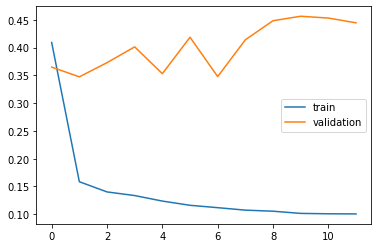


predict: [[31.84964417 22.13058081]]
real:      [[31.3 20.9]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3892 - mean_squared_error: 0.2034 - val_loss: 0.3856 - val_mean_squared_error: 0.1517
Epoch 2/1000
 - 1s - loss: 0.1598 - mean_squared_error: 0.0409 - val_loss: 0.2381 - val_mean_squared_error: 0.0654
Epoch 3/1000
 - 1s - loss: 0.1433 - mean_squared_error: 0.0324 - val_loss: 0.2533 - val_mean_squared_error: 0.0670
Epoch 4/1000
 - 1s - loss: 0.1374 - mean_squared_error: 0.0296 - val_loss: 0.2985 - val_mean_squared_error: 0.0921
Epoch 5/1000
 - 1s - loss: 0.1304 - mean_squared_error: 0.0275 - val_loss: 0.2782 - val_mean_squared_error: 0.0791
Epoch 6/1000
 - 1s - loss: 0.1230 - mean_squared_error: 0.0245 - val_loss: 0.3591 - val_mean_squared_error: 0.1312
Epoch 7/1000
 - 1s - loss: 0.1220 - mean_squared_error: 0.0248 - val_loss: 0.3194 - val_mean_squared_error: 0.1056
Epoch 8/1000
 - 1s - loss: 0.1179 - mean_squared_error: 0.0228 - val_loss: 0.2983 - va

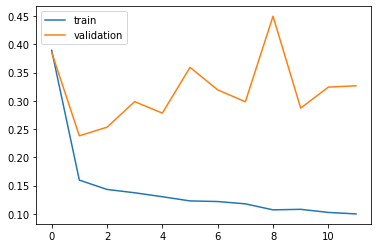


predict: [[33.20605819 21.97063111]]
real:      [[25.9 21.2]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5237 - mean_squared_error: 0.3112 - val_loss: 0.1123 - val_mean_squared_error: 0.0127
Epoch 2/1000
 - 1s - loss: 0.1897 - mean_squared_error: 0.0549 - val_loss: 0.2134 - val_mean_squared_error: 0.0531
Epoch 3/1000
 - 1s - loss: 0.1435 - mean_squared_error: 0.0323 - val_loss: 0.1191 - val_mean_squared_error: 0.0142
Epoch 4/1000
 - 1s - loss: 0.1348 - mean_squared_error: 0.0283 - val_loss: 0.1873 - val_mean_squared_error: 0.0352
Epoch 5/1000
 - 1s - loss: 0.1332 - mean_squared_error: 0.0277 - val_loss: 0.1617 - val_mean_squared_error: 0.0270
Epoch 6/1000
 - 1s - loss: 0.1320 - mean_squared_error: 0.0270 - val_loss: 0.1910 - val_mean_squared_error: 0.0374
Epoch 7/1000
 - 1s - loss: 0.1319 - mean_squared_error: 0.0275 - val_loss: 0.1631 - val_mean_squared_error: 0.0277
Epoch 8/1000
 - 1s - loss: 0.1271 - mean_squared_error: 0.0252 - val_loss: 0.1940 - va

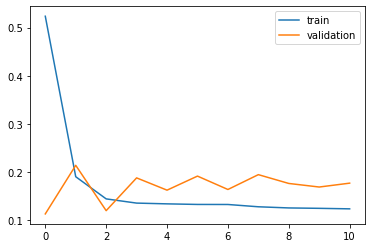


predict: [[29.24714192 20.73336822]]
real:      [[29.2 21.1]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3848 - mean_squared_error: 0.2008 - val_loss: 0.2584 - val_mean_squared_error: 0.0942
Epoch 2/1000
 - 1s - loss: 0.1494 - mean_squared_error: 0.0365 - val_loss: 0.2333 - val_mean_squared_error: 0.0677
Epoch 3/1000
 - 1s - loss: 0.1395 - mean_squared_error: 0.0305 - val_loss: 0.1915 - val_mean_squared_error: 0.0652
Epoch 4/1000
 - 1s - loss: 0.1380 - mean_squared_error: 0.0309 - val_loss: 0.1950 - val_mean_squared_error: 0.0555
Epoch 5/1000
 - 1s - loss: 0.1339 - mean_squared_error: 0.0284 - val_loss: 0.1854 - val_mean_squared_error: 0.0612
Epoch 6/1000
 - 1s - loss: 0.1340 - mean_squared_error: 0.0287 - val_loss: 0.1981 - val_mean_squared_error: 0.0584
Epoch 7/1000
 - 1s - loss: 0.1300 - mean_squared_error: 0.0269 - val_loss: 0.1917 - val_mean_squared_error: 0.0640
Epoch 8/1000
 - 1s - loss: 0.1294 - mean_squared_error: 0.0269 - val_loss: 0.1901 - va

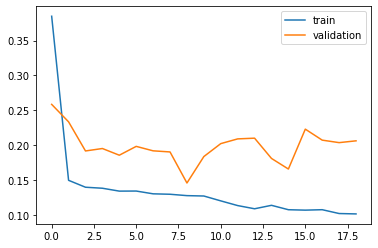


predict: [[30.5724542  22.67604921]]
real:      [[31.1 21.7]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3739 - mean_squared_error: 0.1906 - val_loss: 0.2034 - val_mean_squared_error: 0.0475
Epoch 2/1000
 - 1s - loss: 0.1841 - mean_squared_error: 0.0540 - val_loss: 0.0404 - val_mean_squared_error: 0.0020
Epoch 3/1000
 - 1s - loss: 0.1460 - mean_squared_error: 0.0343 - val_loss: 0.0791 - val_mean_squared_error: 0.0111
Epoch 4/1000
 - 1s - loss: 0.1377 - mean_squared_error: 0.0301 - val_loss: 0.0850 - val_mean_squared_error: 0.0078
Epoch 5/1000
 - 1s - loss: 0.1351 - mean_squared_error: 0.0286 - val_loss: 0.1376 - val_mean_squared_error: 0.0204
Epoch 6/1000
 - 1s - loss: 0.1362 - mean_squared_error: 0.0299 - val_loss: 0.0530 - val_mean_squared_error: 0.0056
Epoch 7/1000
 - 1s - loss: 0.1337 - mean_squared_error: 0.0279 - val_loss: 0.1429 - val_mean_squared_error: 0.0225
Epoch 8/1000
 - 1s - loss: 0.1267 - mean_squared_error: 0.0253 - val_loss: 0.1269 - va

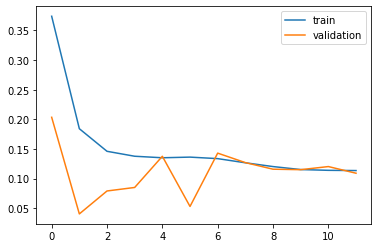


predict: [[31.49675222 21.98468189]]
real:      [[28.7 23.2]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3271 - mean_squared_error: 0.1635 - val_loss: 0.1201 - val_mean_squared_error: 0.0169
Epoch 2/1000
 - 1s - loss: 0.1535 - mean_squared_error: 0.0385 - val_loss: 0.0862 - val_mean_squared_error: 0.0108
Epoch 3/1000
 - 1s - loss: 0.1379 - mean_squared_error: 0.0300 - val_loss: 0.1058 - val_mean_squared_error: 0.0123
Epoch 4/1000
 - 1s - loss: 0.1317 - mean_squared_error: 0.0283 - val_loss: 0.1345 - val_mean_squared_error: 0.0206
Epoch 5/1000
 - 1s - loss: 0.1260 - mean_squared_error: 0.0257 - val_loss: 0.1155 - val_mean_squared_error: 0.0142
Epoch 6/1000
 - 1s - loss: 0.1211 - mean_squared_error: 0.0242 - val_loss: 0.1495 - val_mean_squared_error: 0.0258
Epoch 7/1000
 - 1s - loss: 0.1180 - mean_squared_error: 0.0229 - val_loss: 0.1112 - val_mean_squared_error: 0.0132
Epoch 8/1000
 - 1s - loss: 0.1151 - mean_squared_error: 0.0219 - val_loss: 0.1160 - va

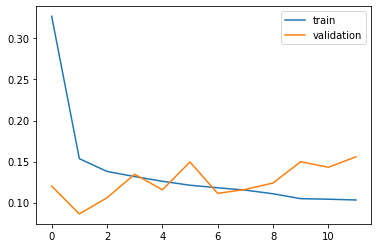


predict: [[32.25565125 22.32460458]]
real:      [[31.2 22.3]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3124 - mean_squared_error: 0.1459 - val_loss: 0.1613 - val_mean_squared_error: 0.0367
Epoch 2/1000
 - 1s - loss: 0.1558 - mean_squared_error: 0.0397 - val_loss: 0.0838 - val_mean_squared_error: 0.0072
Epoch 3/1000
 - 1s - loss: 0.1395 - mean_squared_error: 0.0307 - val_loss: 0.0753 - val_mean_squared_error: 0.0107
Epoch 4/1000
 - 1s - loss: 0.1339 - mean_squared_error: 0.0279 - val_loss: 0.1003 - val_mean_squared_error: 0.0164
Epoch 5/1000
 - 1s - loss: 0.1278 - mean_squared_error: 0.0259 - val_loss: 0.0929 - val_mean_squared_error: 0.0139
Epoch 6/1000
 - 1s - loss: 0.1220 - mean_squared_error: 0.0240 - val_loss: 0.0964 - val_mean_squared_error: 0.0138
Epoch 7/1000
 - 1s - loss: 0.1157 - mean_squared_error: 0.0223 - val_loss: 0.0825 - val_mean_squared_error: 0.0113
Epoch 8/1000
 - 1s - loss: 0.1098 - mean_squared_error: 0.0199 - val_loss: 0.1482 - va

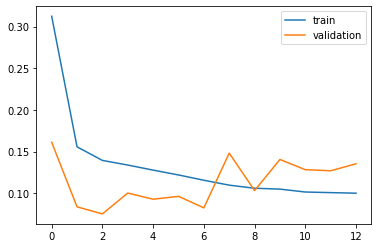


predict: [[32.15955462 22.69234526]]
real:      [[31.1 22.3]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3351 - mean_squared_error: 0.1658 - val_loss: 0.1247 - val_mean_squared_error: 0.0226
Epoch 2/1000
 - 1s - loss: 0.1658 - mean_squared_error: 0.0447 - val_loss: 0.0684 - val_mean_squared_error: 0.0064
Epoch 3/1000
 - 1s - loss: 0.1382 - mean_squared_error: 0.0303 - val_loss: 0.0752 - val_mean_squared_error: 0.0072
Epoch 4/1000
 - 1s - loss: 0.1317 - mean_squared_error: 0.0271 - val_loss: 0.0657 - val_mean_squared_error: 0.0049
Epoch 5/1000
 - 1s - loss: 0.1248 - mean_squared_error: 0.0248 - val_loss: 0.0723 - val_mean_squared_error: 0.0056
Epoch 6/1000
 - 1s - loss: 0.1192 - mean_squared_error: 0.0229 - val_loss: 0.0679 - val_mean_squared_error: 0.0064
Epoch 7/1000
 - 1s - loss: 0.1163 - mean_squared_error: 0.0221 - val_loss: 0.0646 - val_mean_squared_error: 0.0055
Epoch 8/1000
 - 1s - loss: 0.1131 - mean_squared_error: 0.0210 - val_loss: 0.0723 - va

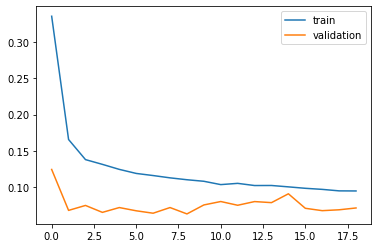


predict: [[31.29050686 22.27600543]]
real:      [[31.  22.8]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 0.2814 - mean_squared_error: 0.1187 - val_loss: 0.1280 - val_mean_squared_error: 0.0313
Epoch 2/1000
 - 1s - loss: 0.1531 - mean_squared_error: 0.0367 - val_loss: 0.1149 - val_mean_squared_error: 0.0152
Epoch 3/1000
 - 1s - loss: 0.1406 - mean_squared_error: 0.0318 - val_loss: 0.1101 - val_mean_squared_error: 0.0159
Epoch 4/1000
 - 1s - loss: 0.1330 - mean_squared_error: 0.0283 - val_loss: 0.1143 - val_mean_squared_error: 0.0171
Epoch 5/1000
 - 1s - loss: 0.1267 - mean_squared_error: 0.0258 - val_loss: 0.0851 - val_mean_squared_error: 0.0115
Epoch 6/1000
 - 1s - loss: 0.1188 - mean_squared_error: 0.0231 - val_loss: 0.0735 - val_mean_squared_error: 0.0105
Epoch 7/1000
 - 1s - loss: 0.1118 - mean_squared_error: 0.0206 - val_loss: 0.0730 - val_mean_squared_error: 0.0065
Epoch 8/1000
 - 1s - loss: 0.1098 - mean_squared_error: 0.0199 - val_loss: 0.0865 - va

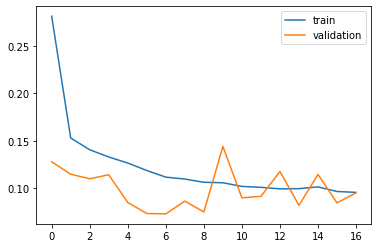


predict: [[30.72241254 22.17667308]]
real:      [[31.5 23. ]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3328 - mean_squared_error: 0.1628 - val_loss: 0.1602 - val_mean_squared_error: 0.0258
Epoch 2/1000
 - 1s - loss: 0.1611 - mean_squared_error: 0.0433 - val_loss: 0.1424 - val_mean_squared_error: 0.0207
Epoch 3/1000
 - 1s - loss: 0.1450 - mean_squared_error: 0.0329 - val_loss: 0.1021 - val_mean_squared_error: 0.0129
Epoch 4/1000
 - 1s - loss: 0.1340 - mean_squared_error: 0.0292 - val_loss: 0.1155 - val_mean_squared_error: 0.0155
Epoch 5/1000
 - 1s - loss: 0.1282 - mean_squared_error: 0.0266 - val_loss: 0.0898 - val_mean_squared_error: 0.0116
Epoch 6/1000
 - 1s - loss: 0.1230 - mean_squared_error: 0.0246 - val_loss: 0.0832 - val_mean_squared_error: 0.0088
Epoch 7/1000
 - 1s - loss: 0.1167 - mean_squared_error: 0.0222 - val_loss: 0.0812 - val_mean_squared_error: 0.0122
Epoch 8/1000
 - 1s - loss: 0.1110 - mean_squared_error: 0.0206 - val_loss: 0.0881 - va

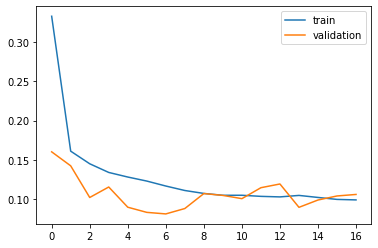


predict: [[31.30262684 22.87612681]]
real:      [[30.9 22.9]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3105 - mean_squared_error: 0.1446 - val_loss: 0.3093 - val_mean_squared_error: 0.0991
Epoch 2/1000
 - 1s - loss: 0.1539 - mean_squared_error: 0.0379 - val_loss: 0.2262 - val_mean_squared_error: 0.0513
Epoch 3/1000
 - 0s - loss: 0.1409 - mean_squared_error: 0.0321 - val_loss: 0.1597 - val_mean_squared_error: 0.0260
Epoch 4/1000
 - 1s - loss: 0.1332 - mean_squared_error: 0.0288 - val_loss: 0.1942 - val_mean_squared_error: 0.0391
Epoch 5/1000
 - 0s - loss: 0.1278 - mean_squared_error: 0.0267 - val_loss: 0.2096 - val_mean_squared_error: 0.0448
Epoch 6/1000
 - 0s - loss: 0.1241 - mean_squared_error: 0.0251 - val_loss: 0.2456 - val_mean_squared_error: 0.0609
Epoch 7/1000
 - 0s - loss: 0.1227 - mean_squared_error: 0.0248 - val_loss: 0.2615 - val_mean_squared_error: 0.0713
Epoch 8/1000
 - 0s - loss: 0.1169 - mean_squared_error: 0.0227 - val_loss: 0.2313 - va

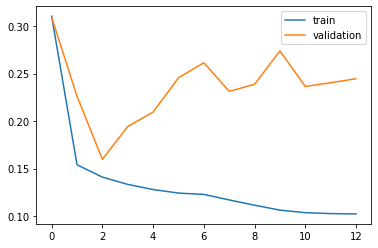


predict: [[31.87160836 22.1848433 ]]
real:      [[31.2 23.2]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4263 - mean_squared_error: 0.2413 - val_loss: 0.1104 - val_mean_squared_error: 0.0124
Epoch 2/1000
 - 0s - loss: 0.1653 - mean_squared_error: 0.0458 - val_loss: 0.1868 - val_mean_squared_error: 0.0485
Epoch 3/1000
 - 0s - loss: 0.1454 - mean_squared_error: 0.0332 - val_loss: 0.2004 - val_mean_squared_error: 0.0744
Epoch 4/1000
 - 0s - loss: 0.1404 - mean_squared_error: 0.0316 - val_loss: 0.2012 - val_mean_squared_error: 0.0674
Epoch 5/1000
 - 1s - loss: 0.1367 - mean_squared_error: 0.0302 - val_loss: 0.1969 - val_mean_squared_error: 0.0687
Epoch 6/1000
 - 0s - loss: 0.1333 - mean_squared_error: 0.0289 - val_loss: 0.1981 - val_mean_squared_error: 0.0673
Epoch 7/1000
 - 0s - loss: 0.1283 - mean_squared_error: 0.0269 - val_loss: 0.1952 - val_mean_squared_error: 0.0708
Epoch 8/1000
 - 0s - loss: 0.1179 - mean_squared_error: 0.0230 - val_loss: 0.1964 - va

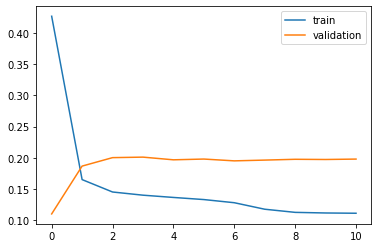


predict: [[29.48668574 22.90896943]]
real:      [[31.  21.1]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3680 - mean_squared_error: 0.1926 - val_loss: 0.1603 - val_mean_squared_error: 0.0470
Epoch 2/1000
 - 0s - loss: 0.1577 - mean_squared_error: 0.0393 - val_loss: 0.1126 - val_mean_squared_error: 0.0162
Epoch 3/1000
 - 0s - loss: 0.1442 - mean_squared_error: 0.0320 - val_loss: 0.1363 - val_mean_squared_error: 0.0358
Epoch 4/1000
 - 0s - loss: 0.1366 - mean_squared_error: 0.0289 - val_loss: 0.1339 - val_mean_squared_error: 0.0260
Epoch 5/1000
 - 1s - loss: 0.1323 - mean_squared_error: 0.0272 - val_loss: 0.1324 - val_mean_squared_error: 0.0254
Epoch 6/1000
 - 1s - loss: 0.1241 - mean_squared_error: 0.0247 - val_loss: 0.1402 - val_mean_squared_error: 0.0309
Epoch 7/1000
 - 1s - loss: 0.1178 - mean_squared_error: 0.0221 - val_loss: 0.0864 - val_mean_squared_error: 0.0125
Epoch 8/1000
 - 1s - loss: 0.1162 - mean_squared_error: 0.0219 - val_loss: 0.0910 - va

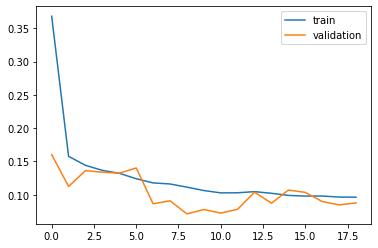


predict: [[31.11553176 22.37836289]]
real:      [[28.7 22.8]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5901 - mean_squared_error: 0.3851 - val_loss: 0.3234 - val_mean_squared_error: 0.1219
Epoch 2/1000
 - 0s - loss: 0.3969 - mean_squared_error: 0.2123 - val_loss: 0.3654 - val_mean_squared_error: 0.1342
Epoch 3/1000
 - 1s - loss: 0.3263 - mean_squared_error: 0.1602 - val_loss: 0.2579 - val_mean_squared_error: 0.0768
Epoch 4/1000
 - 1s - loss: 0.2957 - mean_squared_error: 0.1341 - val_loss: 0.2648 - val_mean_squared_error: 0.0715
Epoch 5/1000
 - 1s - loss: 0.2674 - mean_squared_error: 0.1097 - val_loss: 0.2461 - val_mean_squared_error: 0.0606
Epoch 6/1000
 - 1s - loss: 0.2407 - mean_squared_error: 0.0886 - val_loss: 0.2147 - val_mean_squared_error: 0.0464
Epoch 7/1000
 - 0s - loss: 0.2133 - mean_squared_error: 0.0696 - val_loss: 0.1929 - val_mean_squared_error: 0.0412
Epoch 8/1000
 - 1s - loss: 0.1871 - mean_squared_error: 0.0533 - val_loss: 0.1537 - va

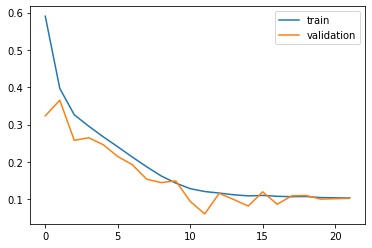


predict: [[32.35156618 22.18256021]]
real:      [[30.1 22.9]]

Train and validation time: 6.963972544670105



In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

min_max_scaler = preprocessing.MinMaxScaler()
values_scaled = min_max_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

inicio = time.time()
result = NCV(dataset_scaled, days_to_predict, min_max_scaler)
fim = time.time()
print('Train and validation time: {}\n'.format((fim - inicio)/60))

In [13]:
y_hats = result[0]
y_tests = result[1]

metrics(y_hats, y_tests)

Maximum metrics
Test RMSE -------------------------- 2.056
Test VARIANCE ---------------------- -0.8567
Test MAX-ERROR --------------------- 7.306
Test MEAN-ABSOLUTE-ERROR ----------- 1.491
Test MEDIAN-ABSOLUTE-ERROR --------- 1.058

Errors
30/04/2018 = 2.498865658044817
29/04/2018 = 2.8153914749622366
28/04/2018 = 0.853714108467095
27/04/2018 = 0.5259884357452336
26/04/2018 = 1.7428668022155769
25/04/2018 = 1.1650015175342574
24/04/2018 = 1.7287969112396233
23/04/2018 = 0.9924591183662415
22/04/2018 = 1.219339805841443
21/04/2018 = 0.5374547123909039
20/04/2018 = 0.10388637781142762
19/04/2018 = 2.4410389035940128
18/04/2018 = 0.8066421508789077
17/04/2018 = 3.8312962591648123
16/04/2018 = 1.0844161093235059
15/04/2018 = 0.7223753094673171
14/04/2018 = 0.5496441721916163
13/04/2018 = 7.306058192253111
12/04/2018 = 0.0471419155597701
11/04/2018 = 0.5275457978248639
10/04/2018 = 2.7967522203922286
9/04/2018 = 1.0556512534618392
8/04/2018 = 1.0595546185970228
7/04/2018 = 0.29050685763359